In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

# Kaggle
-- Create Token API

https://www.kaggle.com/settings/account

Using Kaggle's beta API, you can interact with Competitions and Datasets to download data, make submissions, and more via the command line.

kaggle.json to use the API.

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ankitasawarkar","key":"b1d1a82e88acb7941158005f373703a9"}'}

In [3]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

# Download COVID Face Mask Detection Dataset

In [4]:
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

 94% 195M/207M [00:01<00:00, 127MB/s]
100% 207M/207M [00:01<00:00, 111MB/s]


unzip the folder

In [5]:
!unzip \*.zip

Archive:  covid-face-mask-detection-dataset.zip
  inflating: New Masks Dataset/Test/Mask/2070.jpg  
  inflating: New Masks Dataset/Test/Mask/2072.jpg  
  inflating: New Masks Dataset/Test/Mask/2083.jpg  
  inflating: New Masks Dataset/Test/Mask/2085.jpg  
  inflating: New Masks Dataset/Test/Mask/2086.jpg  
  inflating: New Masks Dataset/Test/Mask/2110.jpg  
  inflating: New Masks Dataset/Test/Mask/2113.jpg  
  inflating: New Masks Dataset/Test/Mask/2114.jpeg  
  inflating: New Masks Dataset/Test/Mask/2130.jpg  
  inflating: New Masks Dataset/Test/Mask/2132.jpg  
  inflating: New Masks Dataset/Test/Mask/2135.jpg  
  inflating: New Masks Dataset/Test/Mask/2154.png  
  inflating: New Masks Dataset/Test/Mask/2158.png  
  inflating: New Masks Dataset/Test/Mask/2159.png  
  inflating: New Masks Dataset/Test/Mask/2160.png  
  inflating: New Masks Dataset/Test/Mask/2170.png  
  inflating: New Masks Dataset/Test/Mask/2172.png  
  inflating: New Masks Dataset/Test/Mask/2173.png  
  inflating: Ne

check all folders and files in "New Masks Dataset"

In [6]:
for dirpath,dirnames,filenames in os.walk("/content/New Masks Dataset"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/New Masks Dataset'.
there are 2 directories and 0 images in '/content/New Masks Dataset/Validation'.
there are 0 directories and 153 images in '/content/New Masks Dataset/Validation/Non Mask'.
there are 0 directories and 153 images in '/content/New Masks Dataset/Validation/Mask'.
there are 2 directories and 0 images in '/content/New Masks Dataset/Test'.
there are 0 directories and 50 images in '/content/New Masks Dataset/Test/Non Mask'.
there are 0 directories and 50 images in '/content/New Masks Dataset/Test/Mask'.
there are 2 directories and 0 images in '/content/New Masks Dataset/Train'.
there are 0 directories and 300 images in '/content/New Masks Dataset/Train/Non Mask'.
there are 0 directories and 300 images in '/content/New Masks Dataset/Train/Mask'.


In [7]:
def view_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    img = mpimg.imread(target_folder+"/"+ random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    print(f"image shape {img.shape}")

    return img

['64.jpg']
image shape (428, 320, 3)


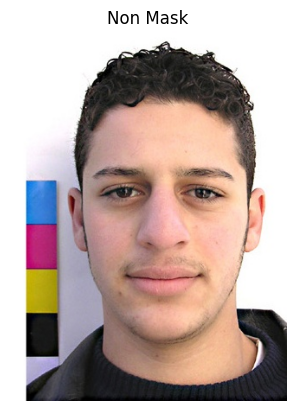

In [8]:
img = view_image("/content/New Masks Dataset/Train/","Non Mask")

['1631.jpg']
image shape (1024, 976, 3)


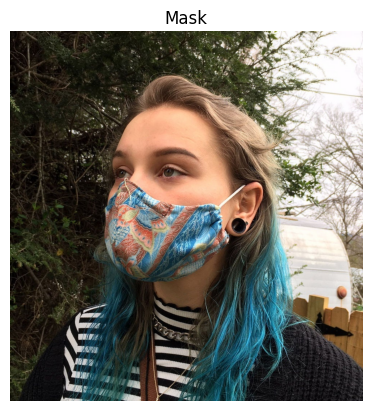

In [9]:
img = view_image("/content/New Masks Dataset/Train/","Mask")

Resize the Non mask and mask images of train and test folder

In [10]:
data=[]
labels=[]
no_mask=os.listdir("/content/New Masks Dataset/Train/Non Mask/")
for a in no_mask:

    image = cv2.imread("/content/New Masks Dataset/Train/Non Mask/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(0)

no_mask=os.listdir("/content/New Masks Dataset/Test/Non Mask/")
for a in no_mask:

    image = cv2.imread("/content/New Masks Dataset/Test/Non Mask/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(0)

In [11]:

mask=os.listdir("/content/New Masks Dataset/Train/Mask/")
for a in mask:

    image = cv2.imread("/content/New Masks Dataset/Train/Mask/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(1)


mask=os.listdir("/content/New Masks Dataset/Test/Mask/")
for a in mask:

    image = cv2.imread("/content/New Masks Dataset/Test/Mask/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(1)

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

standardize the images

In [12]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [13]:
data.shape  # (numbers of images, hight, width, depth or channel)

(700, 224, 224, 3)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42,shuffle=True,
                                                    stratify = labels)

MobileNet is predefine model. We can freez last layer and add our respective layer to get required output.

All predefined applications present in tensorflow model zoo with respective speed and accuracy.
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

The model is set up to be trained using Stochastic Gradient Descent (SGD) as the optimizer, binary cross-entropy as the loss function (suitable for binary classification problems), and the accuracy metric will be monitored during training.

In [15]:
base_model = tf.keras.applications.MobileNet(input_shape=[224,224,3], weights = "imagenet", include_top=False)

base_model.trainable = False

# for layer in base_model.layers[30:]:
#   layer.trainable = False

# set hyperparameters
model = Flatten()(base_model.output)
model = Dense(units=256, activation="relu")(model) # [L-2] layer, with hidden units 256 and activation function ReLU
model = Dense(units=64, activation="relu")(model) # [L-1] layer, with hidden units 256 and activation function ReLU
prediction_layer = Dense(units=1, activation="sigmoid")(model) # last [L] output layer, one output is there between 0 to 1 becz of sigmoid

model = Model(inputs = base_model.input, outputs = prediction_layer)
model.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])

17225924/17225924 [==============================] - 0s 0us/step


During the fit process, the model will go through the training data for the specified number of epochs, and in each epoch, it will split off the validation data based on the validation_split parameter. The model will then update its weights based on the optimization process using the specified optimizer and loss function, and it will compute and display the accuracy metric on both the training data and the validation data.

In [16]:
model.fit(X_train, y_train, epochs=15,validation_split= 0.1, batch_size=32)

Epoch 1/15
18/18 [==============================] - 15s 144ms/step - loss: 0.6244 - accuracy: 0.8201 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 2/15
18/18 [==============================] - 1s 49ms/step - loss: 0.0222 - accuracy: 0.9982 - val_loss: 0.0158 - val_accuracy: 1.0000
Epoch 3/15
18/18 [==============================] - 1s 51ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 4/15
18/18 [==============================] - 1s 48ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 5/15
18/18 [==============================] - 1s 48ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 6/15
18/18 [==============================] - 1s 50ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 7/15
18/18 [==============================] - 1s 50ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 8/15


 the predict list will contain binary labels (0: Not Mask or 1: Mask) based on the model's predictions for the test data. These labels can be used for evaluation or further analysis of the model's performance on unseen data.

In [17]:
predictions = model.predict(X_test)

predict=[]

for i in range(len(predictions)):
    if predictions[i][0]>0.5:
        predict.append(1)
    else:
        predict.append(0)

3/3 [==============================] - 1s 203ms/step


In [18]:
pd.DataFrame(confusion_matrix(y_test, predict), columns= ["No Mask", "Mask"], index = ["No Mask", "Mask"])

,No Mask,Mask
No Mask,35,0
Mask,0,35


In [20]:
model_name = "/content/mask_detection_model.h5"
tf.keras.models.save_model(model, model_name)